# Getting started with IDC - Part 3: Working with data cohorts

---

## Summary

This notebook is part of [the "Getting started with IDC" notebook series](https://github.com/ImagingDataCommons/IDC-Examples/blob/master/notebooks/getting_started) introducing NCI Imaging Data Commons to the users who want to interact with IDC programmatically.

In Part 1 of this tutorial series, you learned how to complete the prerequisites that are required to be able to search IDC data using GCP BigQuery.

Part 2 introduced you to the basics of exploring IDC metadata and defining subsets of data.

In this notebook you will learn what you can do with the subset, or cohort, that you defined based on the IDC metadata attributes.

---
Initial version: Nov 2022

Updated: 

## What is IDC?

[NCI Imaging Data Commons (IDC)](https://datacommons.cancer.gov/repository/imaging-data-commons) is a cloud-based repository of publicly available cancer imaging data co-located with the analysis and exploration tools and resources. IDC is a node within the broader NCI Cancer Research Data Commons (CRDC) infrastructure that provides secure access to a large, comprehensive, and expanding collection of cancer research data.

## Prerequisites

It is assumed that you completed tutorial 1 in the series. You will need to have a Google identity, Google Cloud activated for that account, and the ID of the project created under that account.

Before doing **anything** you **must**  authorize Colab Runtime to act on your behalf, and initialize the variable pointing to your Google Cloud project ID.

The following cell initializes project ID that is needed for all operations with the cloud. You should have project ID if you completed the [first tutorial](https://github.com/ImagingDataCommons/IDC-Examples/blob/master/notebooks/getting_started/part1_prerequisites.ipynb) in this series.

In [1]:
#@title Enter your Project ID
# initialize this variable with your Google Cloud Project ID!
my_ProjectID = "" #@param {type:"string"}

import os
os.environ["GCP_PROJECT_ID"] = my_ProjectID

from google.colab import auth
auth.authenticate_user()

## What is "cohort"?

In IDC, a _cohort_ is set of objects stored in IDC that share certain characteristics as defined by metadata.

In the previous tutorial you learned how to use IDC metadata and SQL to filter IDC data and define subsets/cohorts based on such metadata characteristics as cancer location or image modality. You also learned about the hierarchy of data organization in IDC, whereas your "cohorts" can be defined at the level of collections, patients, imaging studies, series or individual images (files).

In the following cells we will learn:
1. How to check the license(s) that cover the data included in your cohort, and how to make sure you comply with the usage terms
2. How to download the files corresponding to your cohort
3. How to visualize images from your cohort

## Let's define a cohort

For the sake of this tutorial, let's use one of the queries from part 2 of the series, which selects DICOM identifiers of the studies that contain both CT and SEG modalities from collections where cancer primary site is Lung. Here's that query:

In [ ]:
from google.cloud import bigquery

# BigQuery client is initialized with the ID of the project
# we specified in the beginning of the notebook!
bq_client = bigquery.Client(my_ProjectID)

selection_query = """
WITH
  temp_result AS (
  SELECT
    StudyInstanceUID,
    STRING_AGG(DISTINCT(collection_id)) AS collection_id,
    STRING_AGG(DISTINCT(tcia_tumorLocation)) AS tcia_tumorLocation,
    ARRAY_AGG(DISTINCT(Modality)) AS modalities
  FROM
    bigquery-public-data.idc_current.dicom_all
  GROUP BY
    StudyInstanceUID)
SELECT
  StudyInstanceUID,
  ARRAY_TO_STRING(modalities,",") AS modalities,
  collection_id
FROM
  temp_result
WHERE
  "CT" IN UNNEST(modalities)
  AND "SEG" IN UNNEST(modalities)
  AND tcia_tumorLocation = "Lung"
"""

selection_result = bq_client.query(selection_query)
selection_df = selection_result.result().to_dataframe()

selection_df

## Downloading the cohort

While defining your cohort, you may be looking for subsets of collections, patients or studies that meet your search critieria. But when it comes to downloading the cohort, you will always need to get the URLs of the individual files from the cohort.

The following cell uses the query from the above to get the list of study identifiers that meet our search critieria, and then selects all of the rows correspoing to the DICOM instances (files)that are included in those studies. The column that contains the URI that can be used to download the file is in the `gcs_url` column. We will also query the `instance_size` column, which we can use to calculate the size of the files corresponding to the cohort.

As we learned in the part 2 of this tutorial series, each row of the IDC metadata table corresponds to a single DICOM file, and the attributes we mentioned above are assigned at the granularity of the individual files.

Earlier, we queried for all of the DICOM studies that meet our search criteria. Studies consist of series, and series consist of instances (files). This time, let's retrieve all of the rows that are included in our cohort, and select `collection_id`, `license` and `source_url` columns. 

In [ ]:
from google.cloud import bigquery

# BigQuery client is initialized with the ID of the project
# we specified in the beginning of the notebook!
bq_client = bigquery.Client(my_ProjectID)

selection_query = """
SELECT
  gcs_url,
  instance_size
FROM
  bigquery-public-data.idc_current.dicom_all
WHERE
  StudyInstanceUID IN 

  # below is the same query we defined earlier
  (
  WITH
    temp_result AS (
    SELECT
      StudyInstanceUID,
      STRING_AGG(DISTINCT(collection_id)) AS collection_id,
      STRING_AGG(DISTINCT(tcia_tumorLocation)) AS tcia_tumorLocation,
      ARRAY_AGG(DISTINCT(Modality)) AS modalities
    FROM
      bigquery-public-data.idc_current.dicom_all
    GROUP BY
      StudyInstanceUID)
  SELECT
    StudyInstanceUID
  FROM
    temp_result
  WHERE
    "CT" IN UNNEST(modalities)
    AND "SEG" IN UNNEST(modalities)
    AND tcia_tumorLocation = "Lung"

  # for the sake of demonstration, we select a single study
  LIMIT
    1
  )
"""

selection_result = bq_client.query(selection_query)
selection_df = selection_result.result().to_dataframe()

size_gb = round(selection_df["instance_size"].sum()/(pow(1024,3)),2)
print(f"Cohort size on disk: {size_gb} Gb")

selection_df

Now that we have URLs of the individual files, we can use `gsutil` command line tool from Google Cloud SDK to download them. When using Colab, Google Cloud SDK is pre-installed, but if you want to download files to your computer directly you will need to install SDK first! Note that download instructions are documented [here](https://learn.canceridc.dev/data/downloading-data).

To download the files, we will first save GCS URLs into the manifest file, and then pass that manifest to `gsutil`.

In [ ]:
selection_df["gcs_url"].to_csv("manifest.txt", header=False, index=False)

!rm -rf downloaded_cohort_files && mkdir downloaded_cohort_files
!cat manifest.txt | gsutil -m cp -I downloaded_cohort_files

Once the cell above is done, you can expand the left-side "Files" panel in the Colab interface and confirm that `downloaded_cohort_files` is not empty.

### Faster download using `s5cmd`

[s5cmd](https://github.com/peak/s5cmd) is an open source very fast S3 and local filesystem execution tool, which, as experiments showed, is significantly faster than the Google-provided `gsutil`.

In [ ]:
!wget https://github.com/peak/s5cmd/releases/download/v2.0.0/s5cmd_2.0.0_Linux-64bit.tar.gz && tar zxf s5cmd_2.0.0_Linux-64bit.tar.gz

!./s5cmd --help

In [6]:
from google.cloud import bigquery

# BigQuery client is initialized with the ID of the project
# we specified in the beginning of the notebook!
bq_client = bigquery.Client(my_ProjectID)

selection_query = """
SELECT
  CONCAT("cp ",REPLACE(gcs_url, "gs://", "s3://"), " .") as s5cmd_command,
  StudyInstanceUID,
FROM
  bigquery-public-data.idc_current.dicom_all
WHERE
  StudyInstanceUID IN 

  # below is the same query we defined earlier
  (
  WITH
    temp_result AS (
    SELECT
      StudyInstanceUID,
      STRING_AGG(DISTINCT(collection_id)) AS collection_id,
      STRING_AGG(DISTINCT(tcia_tumorLocation)) AS tcia_tumorLocation,
      ARRAY_AGG(DISTINCT(Modality)) AS modalities
    FROM
      bigquery-public-data.idc_current.dicom_all
    GROUP BY
      StudyInstanceUID)
  SELECT
    StudyInstanceUID
  FROM
    temp_result
  WHERE
    "CT" IN UNNEST(modalities)
    AND "SEG" IN UNNEST(modalities)
    AND tcia_tumorLocation = "Lung"

  # for the sake of demonstration, we select a single study
  LIMIT
    1
  )
"""

selection_result = bq_client.query(selection_query)
selection_df = selection_result.result().to_dataframe()



In [ ]:
selection_df["s5cmd_command"].to_csv("/content/s5cmd_manifest.txt", header=False, index=False)

!rm -rf downloaded_cohort_files && mkdir downloaded_cohort_files
!cd downloaded_cohort_files && /content/s5cmd --no-sign-request --endpoint-url https://storage.googleapis.com run /content/s5cmd_manifest.txt

## Checking licenses and attribution requirements

IDC collects data from various data coordination centers and program. It is important to appreciate that different components of IDC data are covered by different licenses and have attribution requirements that you must follow when using the data!

To get information about license and usage terms you will need to use couple more columns from the IDC `dicom_all` metadata index:
* `license_short_name`, `license_long_name` and `license_url` contain short and long names of the license and URL where the license can be found
* `source_doi` is the Digital Object Identifier (DOI) (note that not all of the collections have a DOI!)
* `source_url` is the URL where you can learn more about the dataset, in particular about attribution requirements

In the following cell we modify the query used earlier to get all distinct combinations of the license and source URL that are encountered for the files included in our cohort.

In [ ]:
from google.cloud import bigquery

# BigQuery client is initialized with the ID of the project
# we specified in the beginning of the notebook!
bq_client = bigquery.Client(my_ProjectID)

selection_query = """
SELECT
  DISTINCT(collection_id),
  license_long_name,
  license_url,
  source_url
FROM
  bigquery-public-data.idc_current.dicom_all
WHERE
  StudyInstanceUID IN (
  WITH
    temp_result AS (
    SELECT
      StudyInstanceUID,
      STRING_AGG(DISTINCT(collection_id)) AS collection_id,
      STRING_AGG(DISTINCT(tcia_tumorLocation)) AS tcia_tumorLocation,
      ARRAY_AGG(DISTINCT(Modality)) AS modalities
    FROM
      bigquery-public-data.idc_current.dicom_all
    GROUP BY
      StudyInstanceUID)
  SELECT
    StudyInstanceUID
  FROM
    temp_result
  WHERE
    "CT" IN UNNEST(modalities)
    AND "SEG" IN UNNEST(modalities)
    AND tcia_tumorLocation = "Lung"
  )
"""

selection_result = bq_client.query(selection_query)
license_selection_df = selection_result.result().to_dataframe()

license_selection_df

From the result of the query we see above, we can conclude that some of the files in our cohort are covered by a license that has restrictions on commercial use. We can check out the URLs for each of the components of the cohort to learn about the terms of use and attribution requirements.

In [ ]:
license_selection_df['source_url']

You can observe that there are two rows for the collection `qin_lung_ct`, which highlights important point that `collection_id` should be treated as a label grouping together both the items released by the original contributors of what initially formed the collection, but also the analysis results of the data in the original collection that might be contributed later. 

![collection](https://www.dropbox.com/s/ot7dbz5umligji1/collection.png?raw=1)

In the example above, [`qin_lung_ct` collection ](https://doi.org/10.7937/K9/TCIA.2015.NPGZYZBZ) was complemented by the [segmentations of the lung nodules](https://doi.org/10.7937/K9/TCIA.2015.PF0M9REI), with both images and segmentations becoming part of the same collection, but having distinct DOIs and attribution requirements.

## Visualizing imaging studies from the cohort

The cohort you selected consists of images stored in IDC. You can use the IDC image viewer to visualize individual studies without having to download the images or install anything on your computer, or you can use the itkwidgets viewer to visualize your downloaded images directly in your notebook!

### IDC Image Viewer

To view your study with the IDC image viewer all you have to do is append the value of `StudyInstanceUID` to the IDC radiology viewer prefix: `https://viewer.imaging.datacommons.cancer.gov/viewer/`.

In the following cell we select the study from the dataframe that we created earlier and print out the viewer URL to view that study.

In [ ]:
import random

study_UID = selection_df["StudyInstanceUID"].values[0]
print(f"https://viewer.imaging.datacommons.cancer.gov/viewer/{study_UID}")

### itkwidgets

#### With itkwidgets we don't even need to leave the notebook to view our data! We can view the full 3D model or view slices as well as choose whether or not we'd like to display segmentation label maps with our image data.

We will first sort the data by the study and series UID into the PatientID/StudyInstanceUID/Modality/SeriesInstanceUID hierarchy. This will allow us to quickly select which series we'd like to view as our image data (CT) and which we'll view as our label map (SEG).

In [ ]:
# dicomsort is the pythong package that can sort DICOM files into
# folder organization based on user-specified DICOM attributes
!git clone https://github.com/pieper/dicomsort.git

In [12]:
!pip install -q pydicom

In [ ]:
# Sort the data into directories based on study, modality, series, and instance
!mkdir -p IDC_sorted
!python dicomsort/dicomsort.py -k -u downloaded_cohort_files IDC_sorted/%PatientID/%StudyInstanceUID/%Modality/%SeriesInstanceUID/%SOPInstanceUID.dcm

Next we will install and import the packages that we need to read in and display the data.

In [14]:
# Install the packages required for sorting and loading the data as well as visualization
!pip install -q pydicom-seg "itk-io>=5.3.0" "itkwidgets[all]>=1.0a27"

In [15]:
import itk
from itkwidgets import view
# Pydicom-Seg is a layer on top of pydicom that handles DICOM SEG objects.
import pydicom
import pydicom_seg
import numpy as np

We can view our CT data and then we can select a segmentation to overlay with the CT data.

In [16]:
patient_ID = os.listdir(f"IDC_sorted/")[0]
image_series_UID = os.listdir(f"IDC_sorted/{patient_ID}/{study_UID}/CT")[0] # There is only one series with CT data
image = itk.imread(f"IDC_sorted/{patient_ID}/{study_UID}/CT/{image_series_UID}")

In [17]:
label_image_series_UID = os.listdir(f"IDC_sorted/{patient_ID}/{study_UID}/SEG")[0] # Select the first segmentation
label_image_SOP_UID = os.listdir(f"IDC_sorted/{patient_ID}/{study_UID}/SEG/{label_image_series_UID}")[0] # Get the name of the DICOM file

# Read the DICOM SEG object using pydicom and pydicom_seg.
seg_dicom = pydicom.dcmread(f"IDC_sorted/{patient_ID}/{study_UID}/SEG/{label_image_series_UID}/{label_image_SOP_UID}")
seg_reader = pydicom_seg.MultiClassReader()
seg_obj = seg_reader.read(seg_dicom)

# Convert the DICOM SEG object into an itk image, with correct voxel origin, spacing, and directions in physical space.
seg_image = itk.image_from_array(seg_obj.data.astype(np.float32))
seg_image.SetOrigin(seg_obj.origin)
seg_image.SetSpacing(seg_obj.spacing)
seg_image.SetDirection(seg_obj.direction)
interpolator = itk.NearestNeighborInterpolateImageFunction.New(seg_image)
label_image = itk.resample_image_filter(Input=seg_image,
                                            Interpolator=interpolator,
                                            reference_image=image, 
                                            use_reference_image=True)


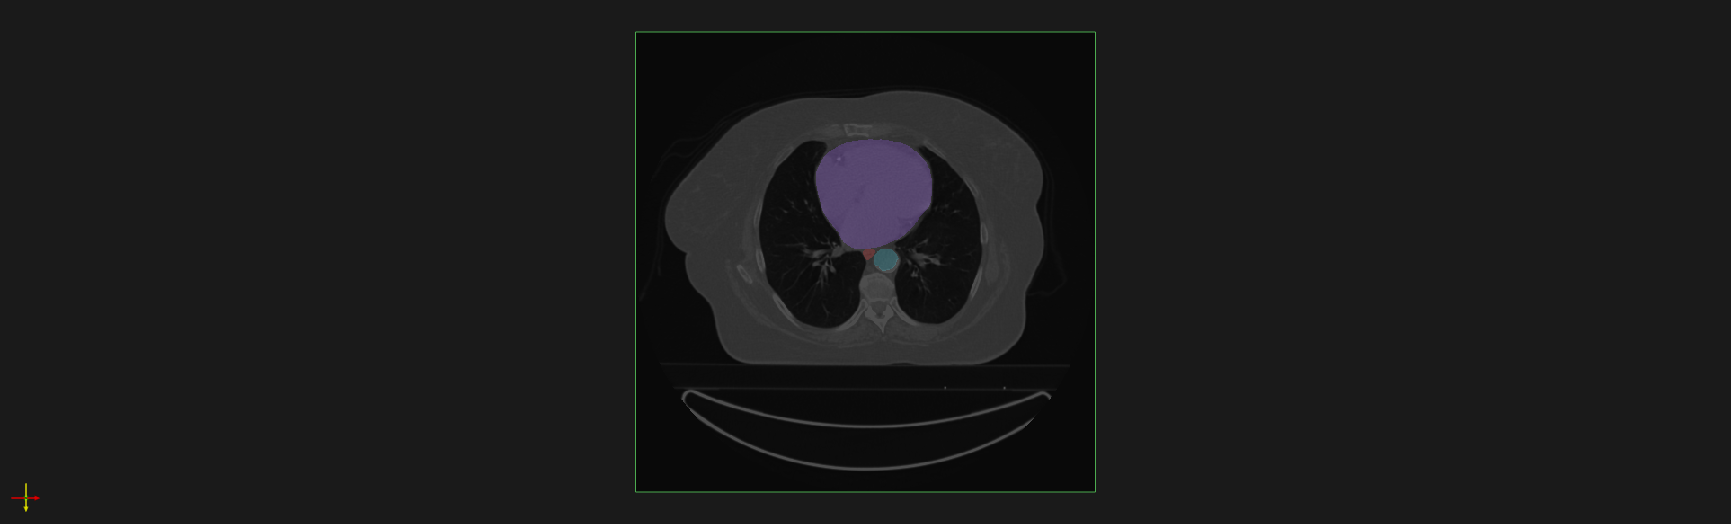
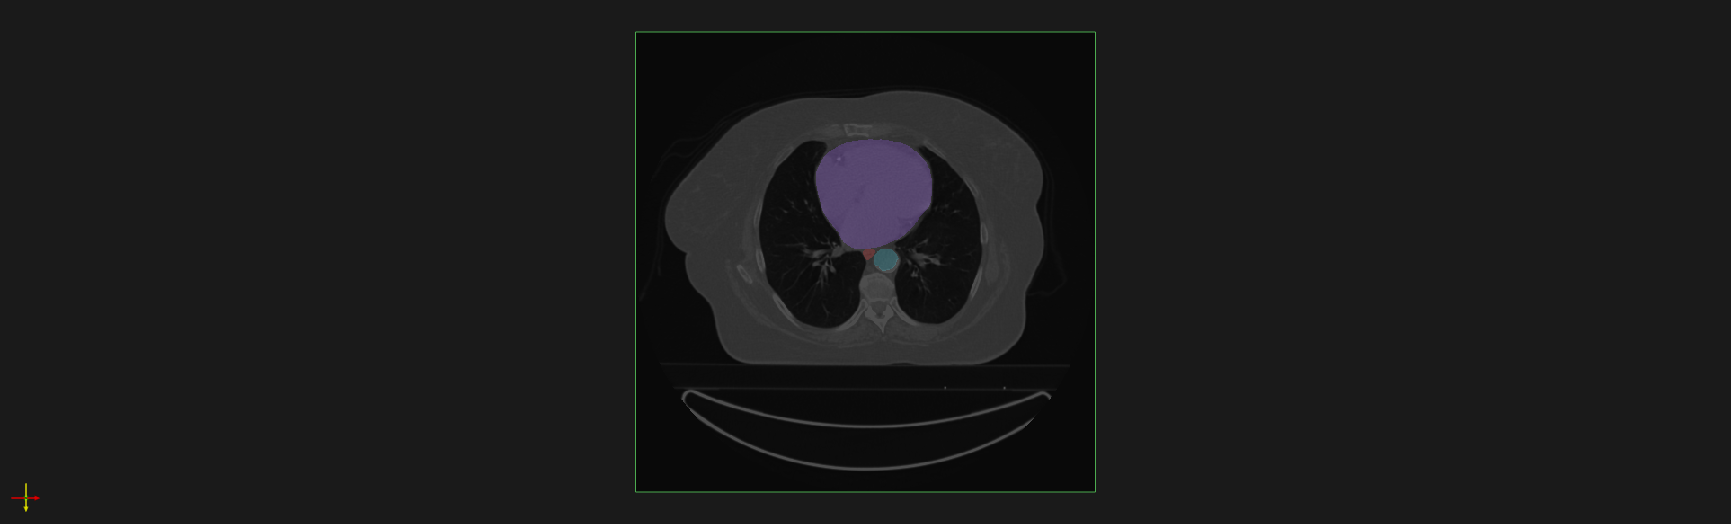

In [18]:
viewer = view(image, label_image=label_image)

While we can always adjust the view using the tools available it can be helpful to save these settings in a cell for reproducibility and easy sharing. Lets adjust the view to make the data a bit clearer.

In [19]:
viewer.set_image_gradient_opacity(0.45)
viewer.set_image_gradient_opacity_scale(0.35)
viewer.set_label_image_blend(0.65)
viewer.set_image_color_range([-829,2251])

Now lets view the z-slice. Press the play button next to the slider under the image to start an animation that moves up and down through all of the slices!

In [20]:
viewer.set_background_color([0.1,0.1,0.1])
viewer.set_image_color_map("Grayscale")
viewer.set_image_color_range([-1727,273])
viewer.set_label_image_blend(0.45)
viewer.set_view_mode('ZPlane')

## Support

You can contact IDC support by sending email to support@canceridc.dev or posting your question on [IDC User forum](https://discourse.canceridc.dev).

## Acknowledgments

Imaging Data Commons has been funded in whole or in part with Federal funds from the National Cancer Institute, National Institutes of Health, under Task Order No. HHSN26110071 under Contract No. HHSN261201500003l.

If you use IDC in your research, please cite the following publication:

> Fedorov, A., Longabaugh, W. J. R., Pot, D., Clunie, D. A., Pieper, S., Aerts, H. J. W. L., Homeyer, A., Lewis, R., Akbarzadeh, A., Bontempi, D., Clifford, W., Herrmann, M. D., Höfener, H., Octaviano, I., Osborne, C., Paquette, S., Petts, J., Punzo, D., Reyes, M., Schacherer, D. P., Tian, M., White, G., Ziegler, E., Shmulevich, I., Pihl, T., Wagner, U., Farahani, K. & Kikinis, R. NCI Imaging Data Commons. Cancer Res. 81, 4188–4193 (2021). http://dx.doi.org/10.1158/0008-5472.CAN-21-0950